# Bayesian Optimization

[Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is used to solve an optimization problem
$$ x^* = \text{arg}\min \ f(x), $$
where $f$ is an unknown objective function which
+ hard to compute,
+ has no derivative,
+ observations of $f$ contain noise.

An optimization process includes constructing a sequence of points $\{x_n\}$ which converges to $x^*$. However, due to the above restrictions, it is hard to construct such sequence using information directly from $f$. In Bayesian Optimization, we put a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) prior on $f$ and derive from it an "acquisition" function $\alpha(x)$ which is easy to evaluate and get derivatives (hence optimizing $\alpha(x)$ is easy). This "acquisition" function encodes the following information about $f$: its minimum is a candidate for $x_n$.

Each time we get more information from $f$, the Gaussian Process model will be updated (similar to the way we update posteriors in Bayesian models) and the derived "acquisition" function will reflect more information about the minimum point of $f$. After a number of steps, it is likely that $\{x_n\}$ will converge to $x^*$.

In this tutorial, we will see how to use the Gaussian Process module in Pyro to do Bayesian Optimization.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import constraints

import pyro
from pyro.contrib.gp.kernels import RBF
from pyro.contrib.gp.models import GPRegression
from pyro.contrib.gp.util import LowerConfidenceBound
from pyro.optim import Adam
pyro.set_rng_seed(0)

import os
smoke_test = ('CI' in os.environ)

## Define a problem

The objective function we are going to solve is
$$f(x) = \frac{x^2}{10} + \sin(x), \quad x\in [-10, 10].$$

In [2]:
def f(x):
    return x**2 / 10 + torch.sin(x)

The minimizer of $f$ is $-1.30644$. Let's take a plot for $x$.

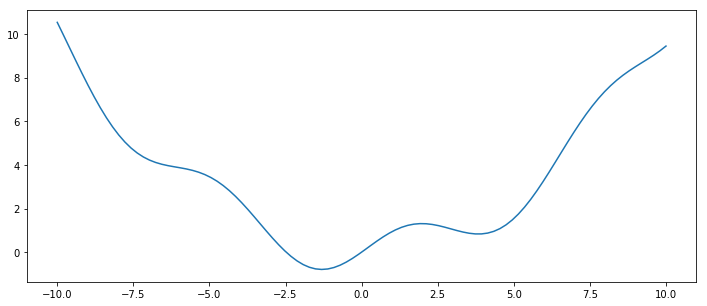

In [3]:
x = torch.linspace(-10, 10)
plt.figure(figsize=(12, 5))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

## Define an acquisition function

We will use the acquisition Lower Confidence Bound (see reference [1]). Its definition is
$$
\alpha(x) = \mu(x) - \kappa \sigma(x),\quad \kappa = 2,
$$
where $\mu(x)$ and $\sigma(x)$ are mean and variance of Gaussian Process posterior. The coefficient $\kappa$ plays a trade-off between exploitation-exploration. A higher $\kappa$, we seek minimum candidates in a higher-uncertainty area, which means we play more weight on exploration. Otherwise, we do exploitation: seek minimum candidates around the posterior mean $\mu(x)$.

For convenience, we created a simple implementation of ``LowerConfidenceBound`` acquisition function in ``pyro.contrib.gp`` module. The class requires a Gaussian Process model and a constraint on input (which is the interval $[-10, 10]$ in our case). In addition, choosing a proper covariance kernel is also very important. Here we use [RBF](https://en.wikipedia.org/wiki/Radial_basis_function) kernel rather than [Matern52](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) kernel (which is suggested in reference [1]) because (from our observations) it gives a better result for this problem.

In [4]:
# give three seeks for Gaussian Process model: -11, 0, and 11
X = torch.linspace(-11, 11, 3)
y = f(X)
gpmodel = GPRegression(X, y, RBF(1), noise=torch.tensor(0.01))
constraint = constraints.interval(-10, 10)
acquisition = LowerConfidenceBound(gpmodel, constraint=constraint)

To illustrate how Bayesian Optimization works, we make a convenient plotting function.

In [5]:
def plot(acquisition, xmin):
    Xnew = torch.linspace(-10, 10)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acquisition.model.X.numpy(), acquisition.model.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = acquisition.model(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot prediction mean
        plt.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    plt.xlim(-10, 10)
    plt.ylabel("Gaussian Process Regression")

    plt.subplot(2, 1, 2)
    with torch.no_grad():
        plt.plot(Xnew.numpy(), acquisition(Xnew).numpy())  # plot acquisition function
        plt.plot(xmin.numpy(), acquisition(xmin).numpy(), "^", markersize=10,
                 label="next x = {:.5f}".format(xmin.item()))  # plot minimum point
    plt.xlim(-10, 10)
    plt.ylabel("Lower Confidence Bound")
    plt.legend()
    plt.show()

### Find $\{x_n\}$

First, given initial seeks (three points $-11, 0, 11$), we fit the Gaussian Process model and find the minimum point from the derived acquisition function.

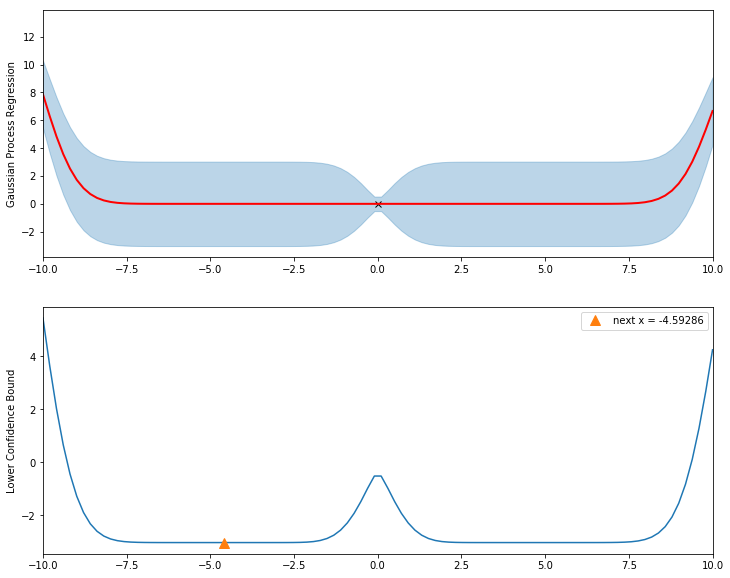

In [6]:
acquisition.model.optimize(Adam({}))
x1 = acquisition.minimum()
plot(acquisition, x1)

After `x1` is found, we update data for the Gaussian Process model. For convenient, the `.update_data(...)` method also fits the Gaussian Process model. Then we find `x2`.

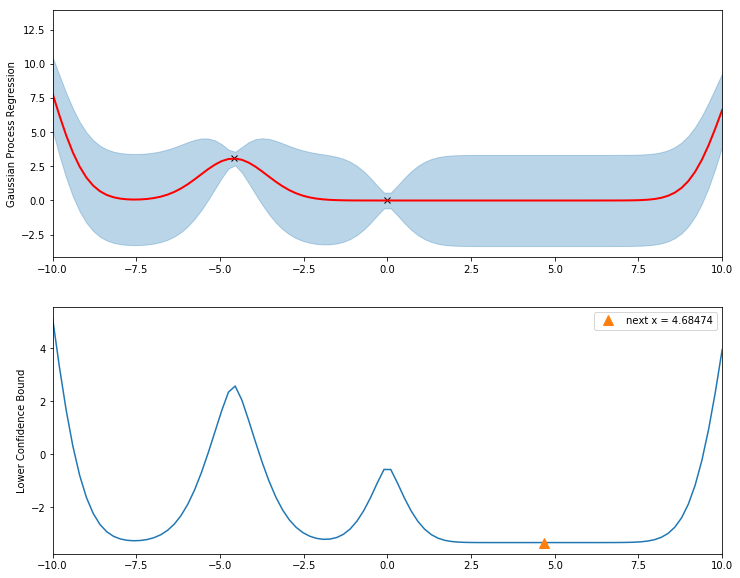

In [7]:
acquisition.update_data(x1, objective=f)
x2 = acquisition.minimum()
plot(acquisition, x2)

The following process illustrates how Gaussian Process posteriors and their derived acquisition functions changes when we observe more data.

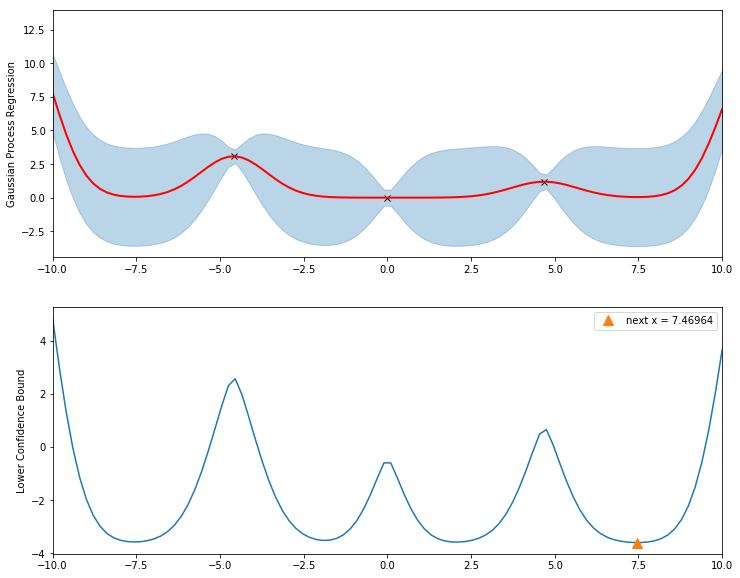

In [8]:
acquisition.update_data(x2, objective=f)
x3 = acquisition.minimum()
plot(acquisition, x3)

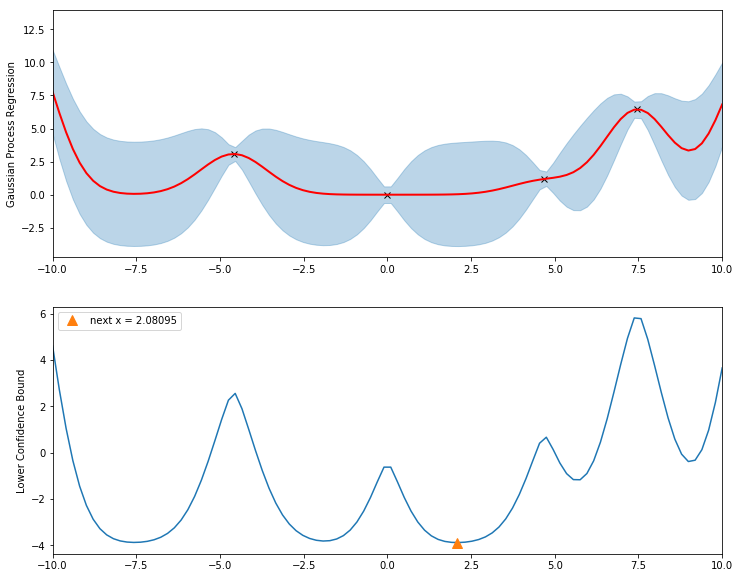

In [9]:
acquisition.update_data(x3, objective=f)
x4 = acquisition.minimum()
plot(acquisition, x4)

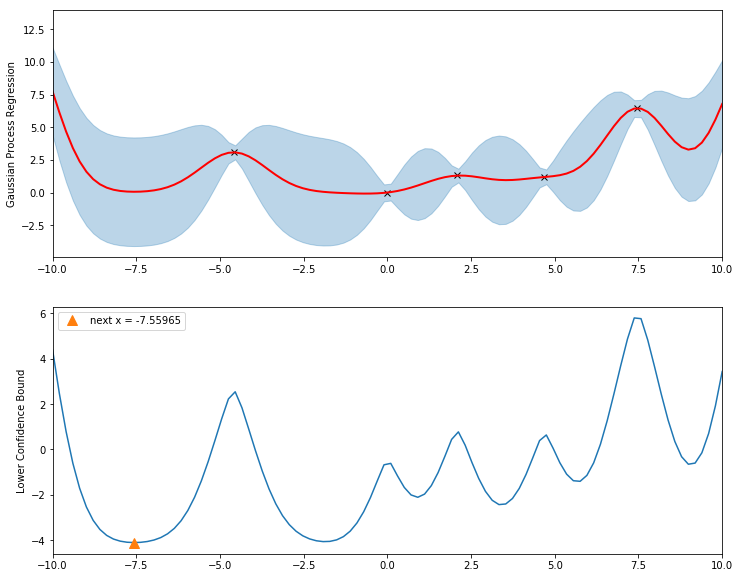

In [10]:
acquisition.update_data(x4, objective=f)
x5 = acquisition.minimum()
plot(acquisition, x5)

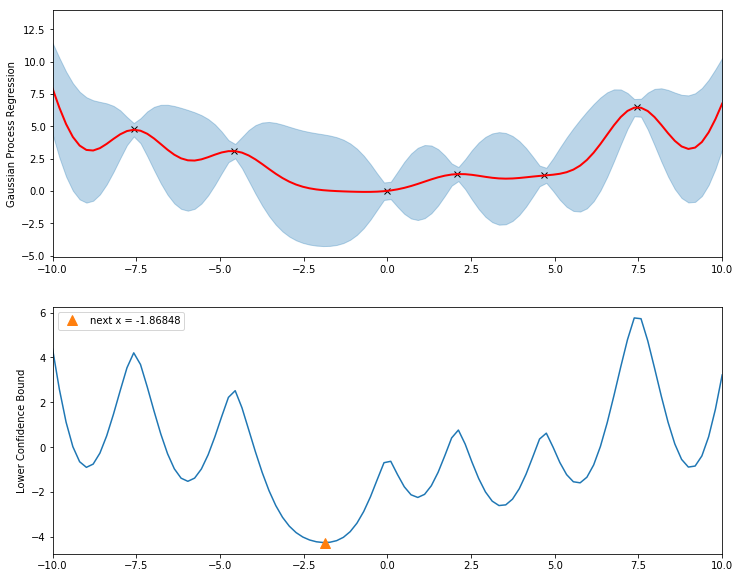

In [11]:
acquisition.update_data(x5, objective=f)
x6 = acquisition.minimum()
plot(acquisition, x6)

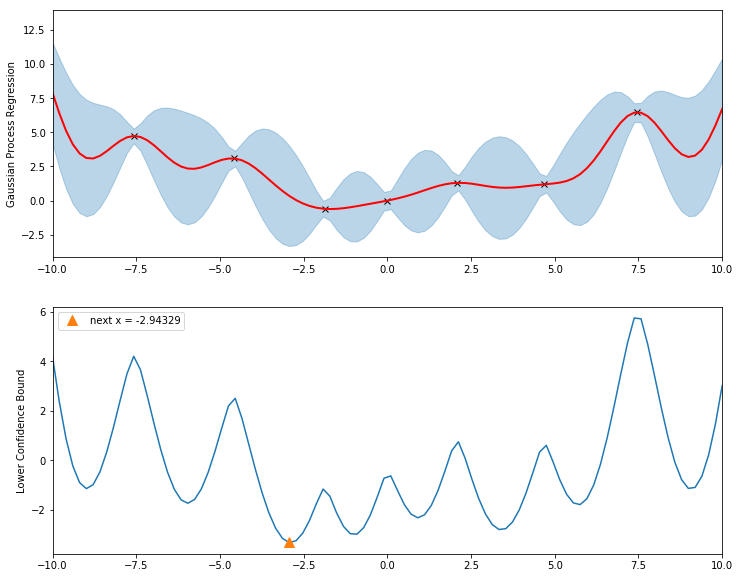

In [12]:
acquisition.update_data(x6, objective=f)
x7 = acquisition.minimum()
plot(acquisition, x7)

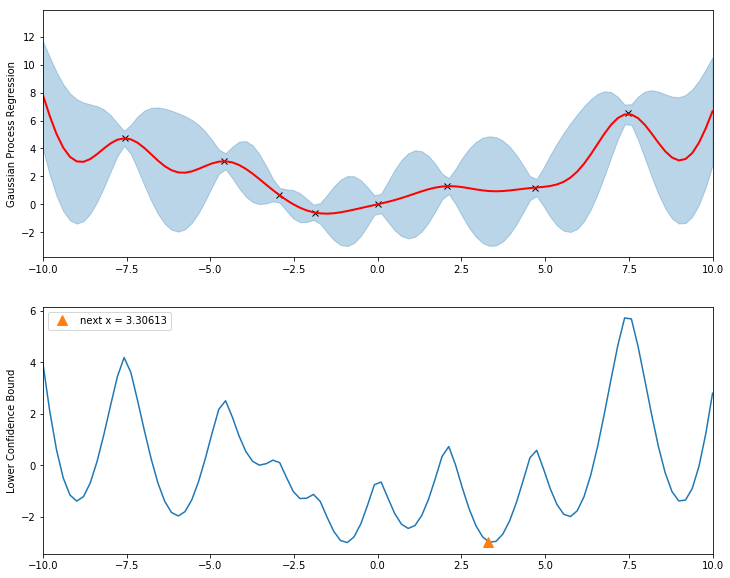

In [13]:
acquisition.update_data(x7, objective=f)
x8 = acquisition.minimum()
plot(acquisition, x8)

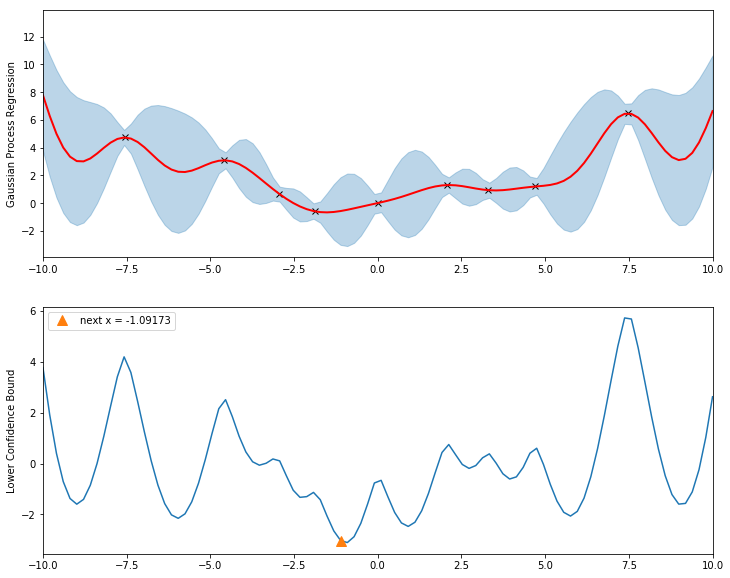

In [14]:
acquisition.update_data(x8, objective=f)
x9 = acquisition.minimum()
plot(acquisition, x9)

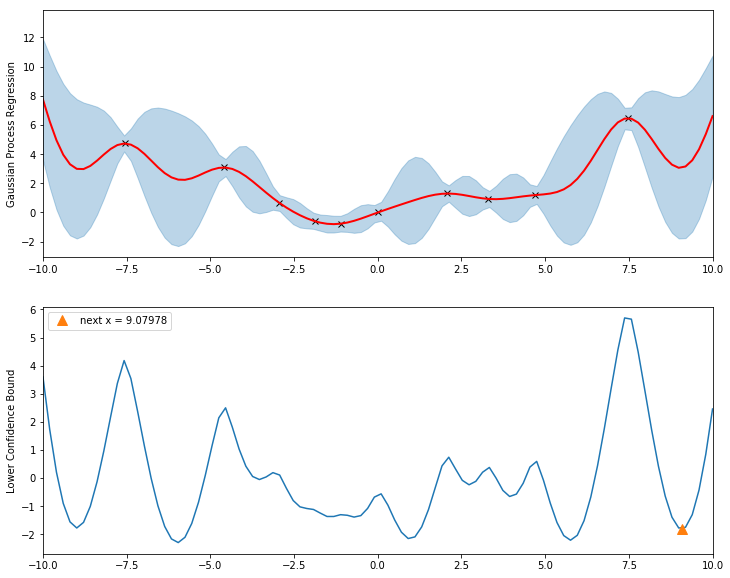

In [15]:
acquisition.update_data(x9, objective=f)
x10 = acquisition.minimum()
plot(acquisition, x10)

At this point, we can see that the acquisition can not find its global minimum. This is a drawback of gradient descent methods!

Finally, to simplify the process, we will run 10 more steps at a time.

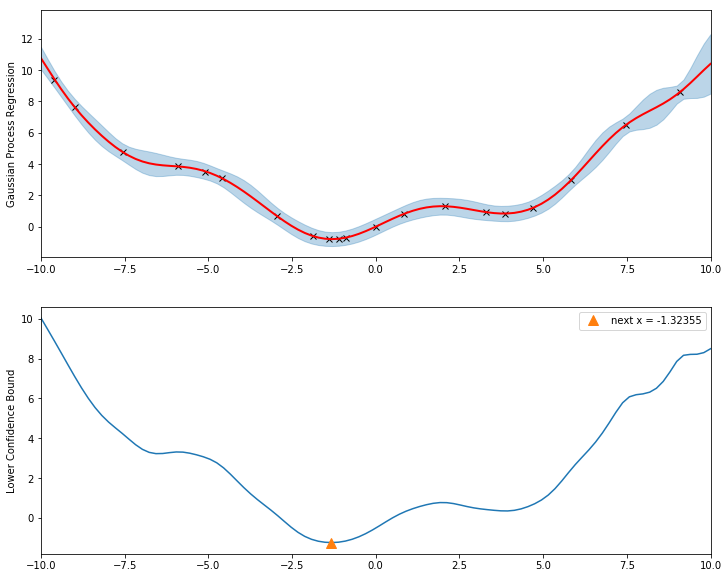

In [16]:
x = x10
num_steps = 10 if not smoke_test else 1
for i in range(num_steps):
    acquisition.update_data(x, objective=f)
    x = acquisition.minimum()
plot(acquisition, x)

Because we made an assumption that our observations contain noise, it is improbable to require an exact result. However, we can see that the sequence still converges to near the global minimum $−1.30644$. That's it! Through this tutorial, we hope that we have conveyed some basic ideas of Bayesian Optimization. The youtube video [3] is an excellent course to learn the basic theory. And the reference [2] gives a review of current progresses on this subject. 

## References

[1] `Practical bayesian optimization of machine learning algorithms`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jasper Snoek, Hugo Larochelle, and Ryan P. Adams

[2] `Taking the human out of the loop: A review of bayesian optimization`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Bobak Shahriari, Kevin Swersky, Ziyu Wang, Ryan P. Adams, and Nando De Freitas

[3] [Machine learning - Bayesian optimization and multi-armed bandits](https://www.youtube.com/watch?v=vz3D36VXefI)